# Investigation of compression for LOW data

Baseline dependent averaging is a form of data compression. In this script, we use a gridded approach to BDA. We create a critically sampled snapshot of a LOW data set, and then compress and decompress it to see what errors result.

In [1]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, create_image_from_array, reproject_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.visibility.compress import compress_visibility, decompress_visibility
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW configuration

In [2]:
low = create_named_configuration('LOWBD2')

In [3]:
oversampling = 2
sampling_time = 35.0 / (oversampling * 8e4)
log.info("Critical sampling time = %.5f (radians) %.2f (seconds)" % 
         (sampling_time, sampling_time * 43200.0 / numpy.pi))
sampling_frequency = 1e8 * 35.0 / (oversampling * 8e4) 
log.info("Critical sampling frequency = %.5f (Hz) " % (sampling_frequency))
times = numpy.arange(- sampling_time, + 1.01 sampling_time, sampling_time)
frequency = numpy.linspace(1e8 - sampling_frequency, 1e8 + sampling_frequency, 3)
print("Observing frequencies %s Hz" % (frequency))

Critical sampling time = 0.00022 (radians) 3.01 (seconds)
Critical sampling frequency = 21875.00000 (Hz) 
Observing frequencies [  9.99781250e+07   1.00000000e+08   1.00021875e+08] Hz


We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [4]:
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, npol=1)

create_visibility: Visibility has 2616320 rows, total size 5.205 GB


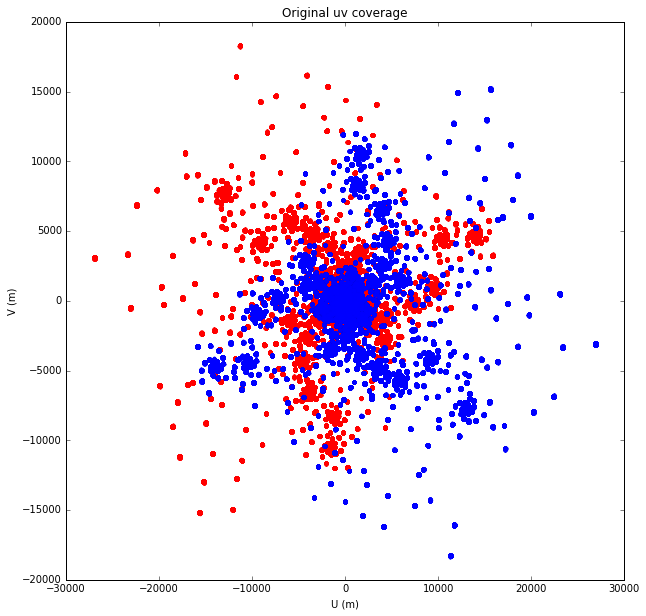

In [5]:
plt.clf()
for chan in range(len(frequency)):
    plt.plot(+vt.uvw_lambda(chan)[:,0], +vt.uvw_lambda(chan)[:,1], '.', color='r')
    plt.plot(-vt.uvw_lambda(chan)[:,0], -vt.uvw_lambda(chan)[:,1], '.', color='b')
plt.title('Original uv coverage')
plt.xlabel('U (m)')
plt.ylabel('V (m)')
plt.show()

Fill the LOW field of view with sources. We create an image just to do the WCS book keeping

In [6]:
vt.data['vis'] *= 0.0
npixel=16384

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.00001, npol=1, nchan=len(frequency))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 16
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([len(frequency)*[100.0 + 2.0 * ix + iy * 20.0]]).transpose()
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc)
            predict_skycomponent_visibility(vt, comp)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining 3 channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 26979.559113 wavelengths
create_image_from_visibility: Critical cellsize = 0.000019 radians, 0.001062 degrees
create_image_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (3, 1, 16384, 16384), size 72.000 (GB)
Spacing in pixels = 1024
Component at (11776.000000, 4608.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 175.62373944, -61.98592937)>
Component at (10752.000000, 4608.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 176.87217021, -62.01921769)>
Component at (9728.000000, 4608.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    ( 178.12252861, -62.04142431)>
Component at (8704.000000, 4608.000000) [0-rel] <SkyCoord (ICRS): (ra

Select the shortest uvw points and form a new visibility set. It is this that we will compress using a grid in u,v space.

create_visibility_from_rows: Created view into visibility table


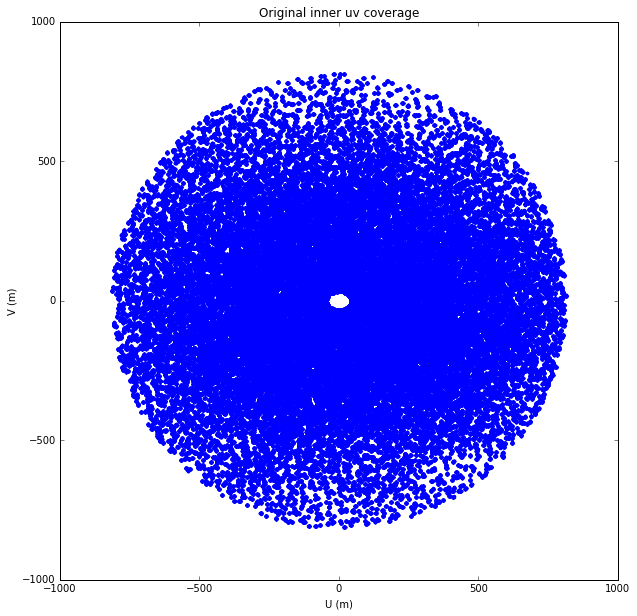

In [7]:
boundary = 0.01
visr = numpy.sqrt(vt.u**2+vt.v**2)
uvmax = numpy.max(visr)
inner_rows = (numpy.abs(visr)  < boundary * uvmax)
vts = create_visibility_from_rows(vt, inner_rows)
plt.clf()
plt.plot(vts.u, vts.v, '.')
plt.title('Original inner uv coverage')
plt.xlabel('U (m)')
plt.ylabel('V (m)')

plt.show()

Create a model to serve as the image specification for the compression. We set the cellsize correspondingly larger so that the sampling of the grid in uv is much finer.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 128, 128), size 0.001 (GB)
get_ftprocessor_params: effective uv cellsize is 3.9 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 3757 rows (1 channels)
Compression using npixel = 128 took 4.0 seconds


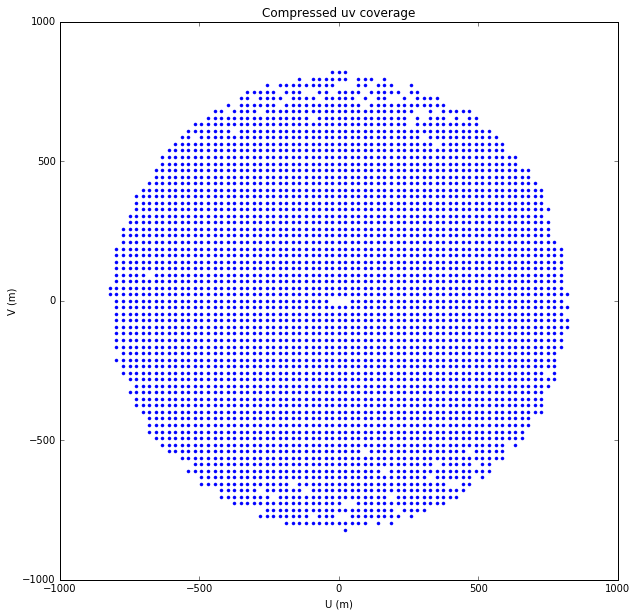

get_ftprocessor_params: effective uv cellsize is 3.9 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 3757 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 128 took 0.2 seconds


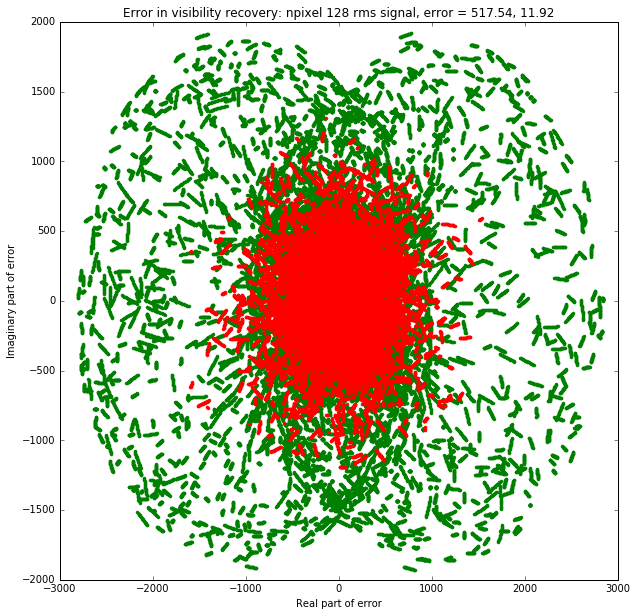

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 256, 256), size 0.006 (GB)
get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 12122 rows (1 channels)
Compression using npixel = 256 took 4.1 seconds


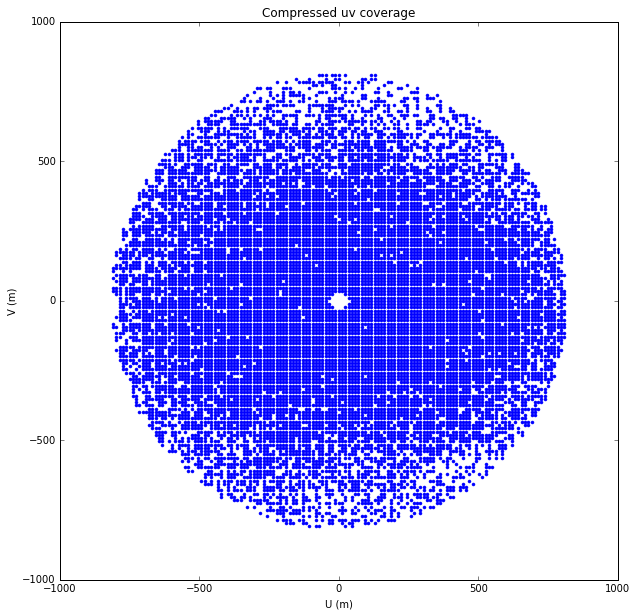

get_ftprocessor_params: effective uv cellsize is 2.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 12122 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 256 took 0.3 seconds


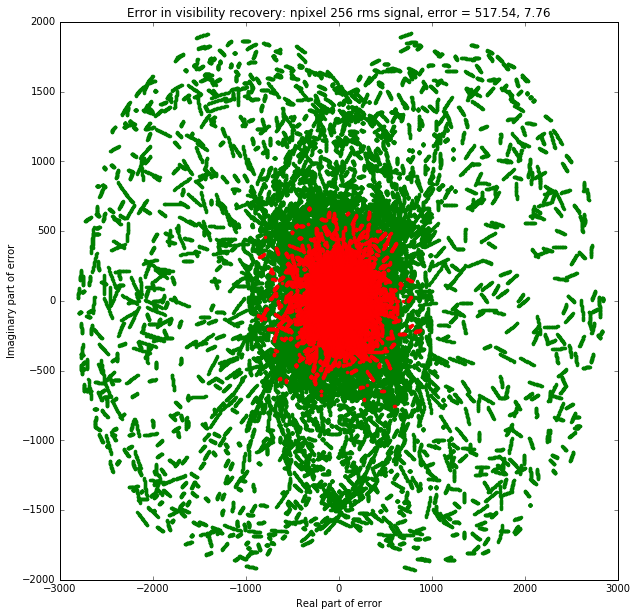

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 512, 512), size 0.023 (GB)
get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 26658 rows (1 channels)
Compression using npixel = 512 took 4.6 seconds


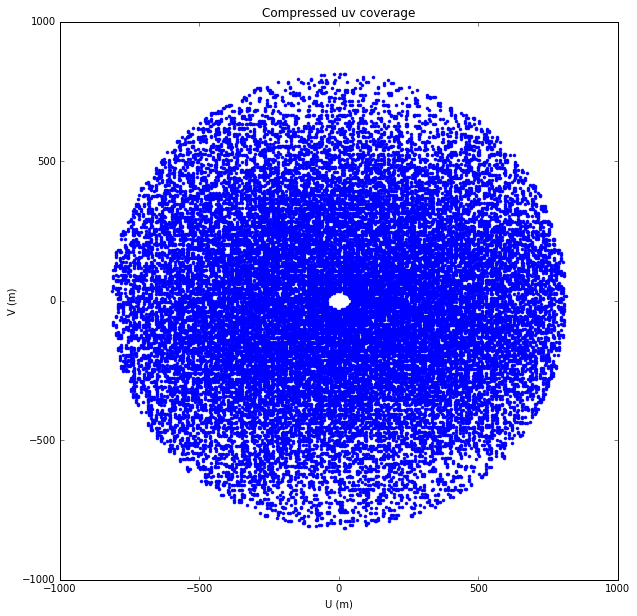

get_ftprocessor_params: effective uv cellsize is 1.0 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 26658 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 512 took 0.3 seconds


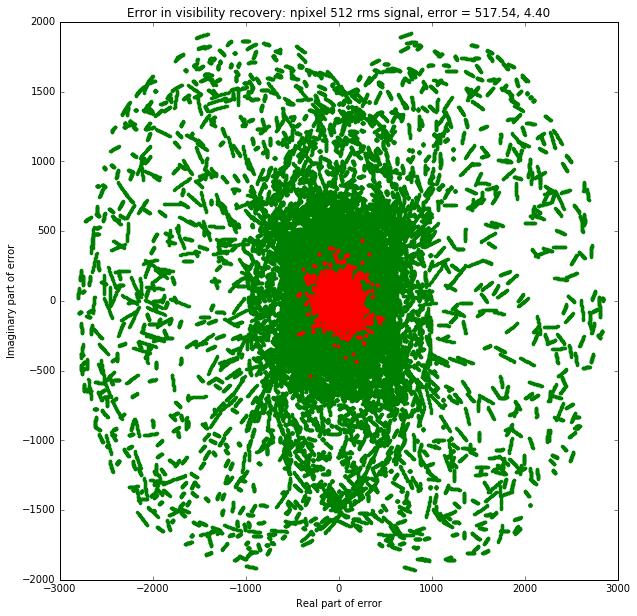

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 1024, 1024), size 0.094 (GB)
get_ftprocessor_params: effective uv cellsize is 0.5 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 43002 rows (1 channels)
Compression using npixel = 1024 took 5.5 seconds


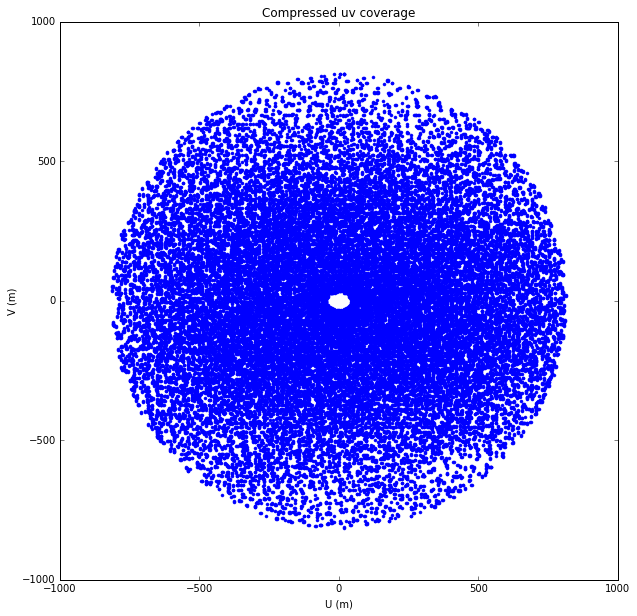

get_ftprocessor_params: effective uv cellsize is 0.5 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 43002 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 1024 took 0.4 seconds


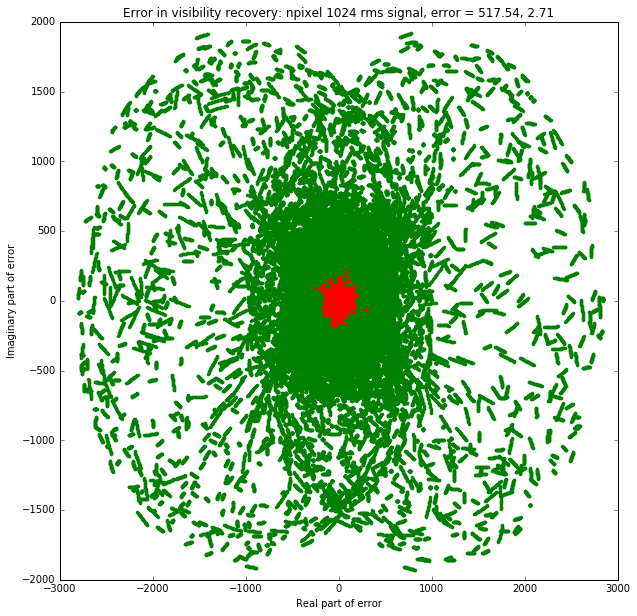

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 2048, 2048), size 0.375 (GB)
get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 66461 rows (1 channels)
Compression using npixel = 2048 took 8.6 seconds


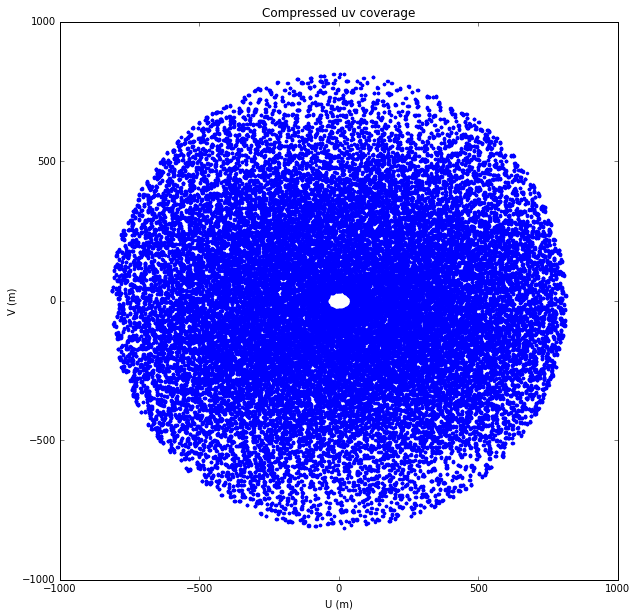

get_ftprocessor_params: effective uv cellsize is 0.2 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 66461 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 2048 took 1.0 seconds


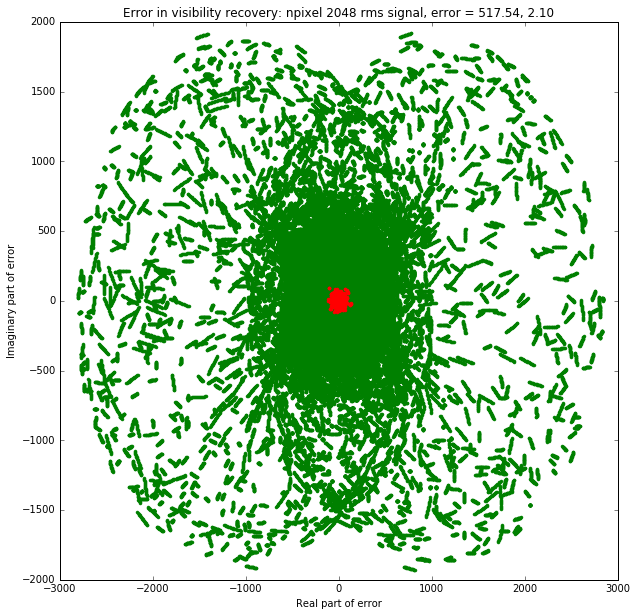

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 4096, 4096), size 1.500 (GB)
get_ftprocessor_params: effective uv cellsize is 0.1 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 114210 rows (1 channels)
Compression using npixel = 4096 took 26.1 seconds


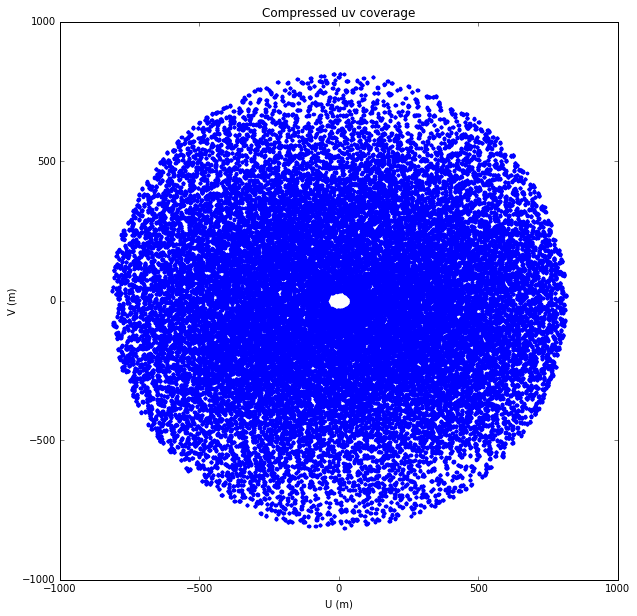

get_ftprocessor_params: effective uv cellsize is 0.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 114210 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 4096 took 3.3 seconds


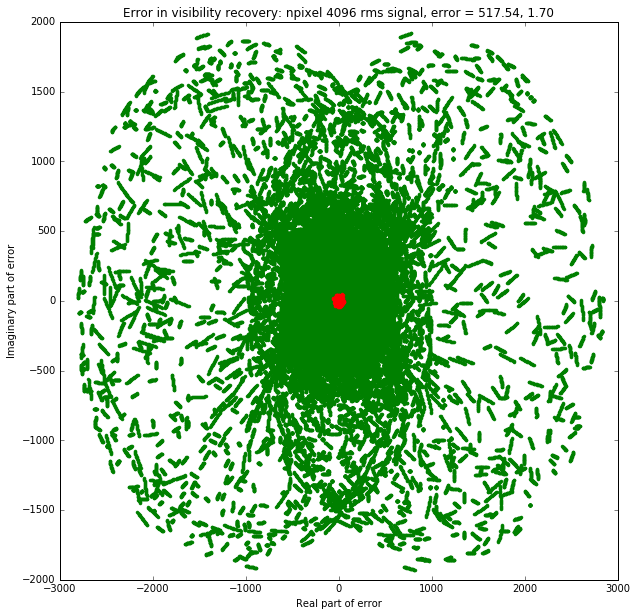

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining MFS Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 180., -60.)>, frequency 99978125.0 Hz, and bandwidth 21875.0 Hz
create_image_from_visibility: uvmax = 271.462836 wavelengths
create_image_from_visibility: Critical cellsize = 0.001842 radians, 0.105532 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
image.operations: created image of shape (1, 1, 8192, 8192), size 6.000 (GB)
get_ftprocessor_params: effective uv cellsize is 0.1 wavelengths
get_ftprocessor_params: Multi-frequency synthesis mode
compress_visibility: Created new Visibility for compressed data
compress_visibility: Compressed 592719 visibility rows (3 channels) into 228236 rows (1 channels)
Compression using npixel = 8192 took 90.8 seconds


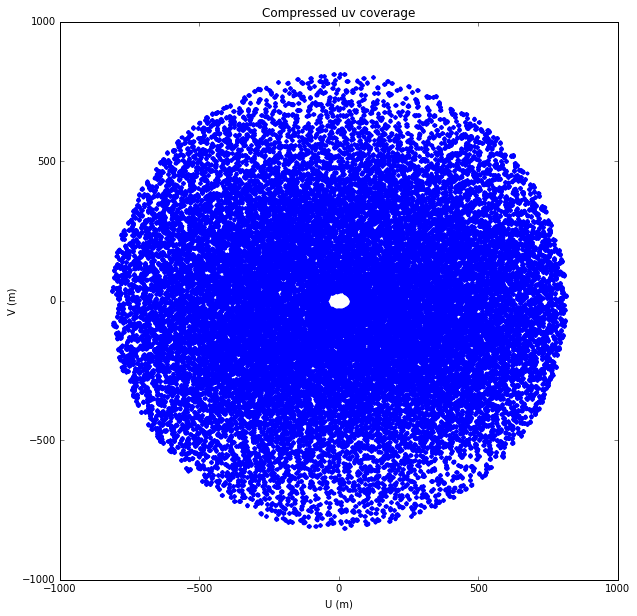

get_ftprocessor_params: effective uv cellsize is 0.1 wavelengths
get_ftprocessor_params: Channel synthesis mode
decompress_visibility: Created new Visibility for decompressed data
decompress_visibility: Decompressing 228236 visibility rows (1 channels) into 592719 rows (3 channels)
Decompression using npixel = 8192 took 21.0 seconds


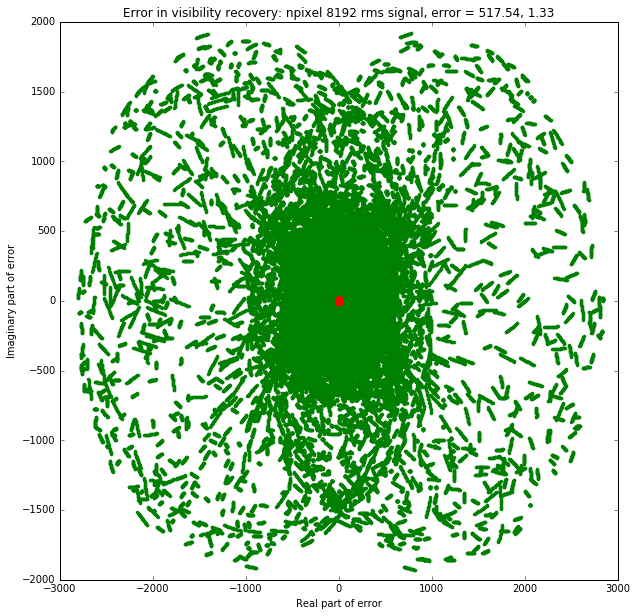

In [8]:
errors = []
signals = []
t_compresses = []
t_decompresses = []

npixels = [128, 256, 512, 1024, 2048, 4096, 8192]

for npixel in npixels:
    model = create_image_from_visibility(vts, npixel=npixel, npol=1, image_nchan=1, cellsize=0.00001/boundary)

    ts = clock()
    cvts = compress_visibility(vts, model)
    t_compress = clock() - ts
    t_compresses.append(t_compress)
    log.debug("Compression using npixel = %d took %.1f seconds" % (npixel, t_compress))


    plt.clf()
    plt.plot(cvts.u, cvts.v, '.')
    plt.title('Compressed uv coverage')
    plt.xlabel('U (m)')
    plt.ylabel('V (m)')
    plt.show()

    template_vis = copy.deepcopy(vts)
    template_vis.data['vis']*=0.0
    ts = clock()
    dcvts = decompress_visibility(cvts, template_vis, model)
    t_decompress = clock() - ts
    t_decompresses.append(t_decompress)
    log.debug("Decompression using npixel = %d took %.1f seconds" % (npixel, t_decompress))


    plt.clf()
    signal = numpy.sqrt(numpy.average(numpy.abs(vts.vis[...,0,0])**2))
    error  = numpy.sqrt(numpy.average(numpy.abs(vts.vis[...,0,0]-dcvts.vis[...,0,0])))
    signals.append(signal)
    errors.append(error)
    plt.plot(vts.vis[...,0,0].real, vts.vis[...,0,0].imag, '.', color='g', label='Visibility')
    plt.plot(vts.vis[...,0,0].real - dcvts.vis[...,0,0].real,  
         vts.vis[...,0,0].imag - dcvts.vis[...,0,0].imag, '.', color='r', label='Error in recovery')
    plt.title("Error in visibility recovery: npixel %d rms signal, error = %.2f, %.2f" % (npixel, signal, error))
    plt.xlabel('Real part of error')
    plt.ylabel('Imaginary part of error')
    plt.show()



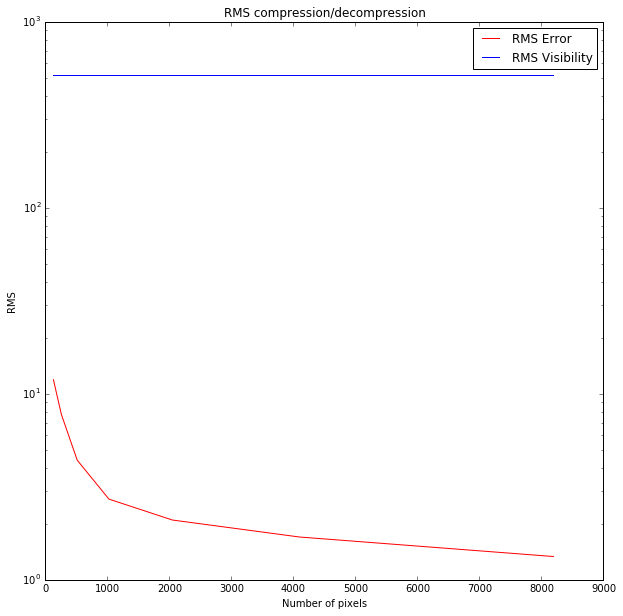

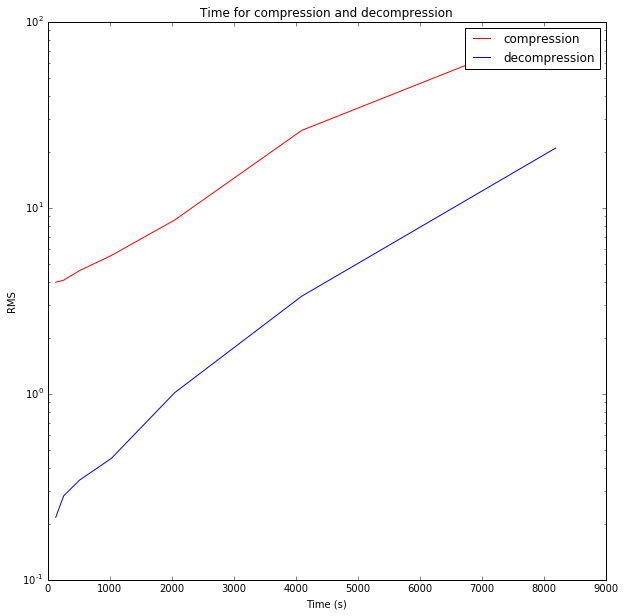

In [9]:
plt.clf()
plt.semilogy(npixels, errors, color='r', label='RMS Error')
plt.semilogy(npixels, signals, color='b', label='RMS Visibility')
plt.title('RMS compression/decompression')
plt.xlabel('Number of pixels')
plt.ylabel('RMS')
plt.legend()
plt.show()
plt.semilogy(npixels, t_compresses, color='r', label='compression')
plt.semilogy(npixels, t_decompresses, color='b', label='decompression')
plt.legend()
plt.title('Time for compression and decompression')
plt.xlabel('Number of pixels')
plt.ylabel('Time (s)')

plt.show()

